In [50]:
import torch

# torch needs to be specified before, otherwise issues with model
import deepsensor.torch
import deepsensor

# from deepsensor.model import ConvNP
from deepsensor.train import Trainer

# load my own function
from kb_utils import construct_circ_and_linear_time_ds

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from tqdm.notebook import tqdm # updated command to avoid warnings

# import logging
# logging.captureWarnings(True)
# logging.captureWarnings(False)

import warnings
# Suppress all MethodRedefinitionWarning
# Potentially dangerous
warnings.filterwarnings("ignore")

import IPython.display as display

In [ ]:
# Define device
print(torch.get_default_device())
deepsensor.train.set_gpu_default_device()
print()
print("Device now:")
print(torch.get_default_device())

# Monthly mass balance change

- preprocessing was applied to generate monthly changes in mass balance as this is much more stationary that modelling the state of mass balance over time.
- We drop another month around the gap between satellite missions as this is a clear outlier (in the validation data).

In [4]:
# load xarray DataSet
mgmb_xds = xr.open_dataset(
    "data/GRACE_COST-G/gmb_gt_validmonths_xda.nc")

mgmb_xds = mgmb_xds.rename_vars({'__xarray_dataarray_variable__': 'mgmb_gt'})

# reorder axis
mgmb_xds = mgmb_xds[["time", "y", "x", "mgmb_gt"]]
# drop outlier value
mgmb_xds = mgmb_xds.drop_sel(time = '2017-06-11T00:00:00.000000000')

In [5]:
switch_index = 161

# extract all months
all_months = mgmb_xds.time.values
print("Number of available months:", all_months.shape[0])

print("")
print("Training")
# subset training months
training_months = all_months[0:switch_index]
print("Number of training months:", training_months.shape[0])
print("Proportion of training data:", np.round(training_months.shape[0]/all_months.shape[0], 2))
print("From", training_months.min().astype('datetime64[M]'), "to", training_months.max().astype('datetime64[M]'))

print("")
print("Validation")
# subset validation months
validation_months = all_months[switch_index:]
print("Number of validation months:", validation_months.shape[0])
print("Proportion of validation data:", np.round(validation_months.shape[0]/all_months.shape[0], 2))
print("From", validation_months.min().astype('datetime64[M]'), "to", validation_months.max().astype('datetime64[M]'))

Number of available months: 224

Training
Number of training months: 161
Proportion of training data: 0.72
From 2002-05 to 2017-05

Validation
Number of validation months: 63
Proportion of validation data: 0.28
From 2018-07 to 2023-11


In [251]:
timeseries_gmb = mgmb_xds.mgmb_gt.sum(dim = ["x", "y"])

fig = go.Figure()

fig.add_trace(go.Scatter(x = timeseries_gmb.time[0:switch_index], 
                         y = timeseries_gmb[0:switch_index], 
                         mode = 'lines+markers',
                         name = 'training data'))

fig.add_trace(go.Scatter(x = timeseries_gmb.time[switch_index:], 
                         y = timeseries_gmb[switch_index:], 
                         mode = 'lines+markers',
                         name = 'validation data'))

fig.update_layout(title = 'Mass balance change in giga tonnes [gt] per month',
                   xaxis_title = 'time',
                   yaxis_title = 'mass balance [gt]')

fig.update_layout(template = "plotly_white")
fig.update_layout(font_family = "Lato")

fig.show()

We observe some seasonality in the overall pattern.

## Convert to dataframe and remove NA's

- 4892 non-empty grid cells 
- 224 months
- 4892 * 224 = 1,095,808 data points

This transformation is needed for off-grid modelling.
A multi-index is automatically used.

In [6]:
mgmb_df = mgmb_xds.to_dataframe()
mgmb_df = mgmb_df.dropna()

mgmb_df

mgmb_gt
time       y          x                 
2002-05-10 -2100000.0 750000.0 -2.056327
                      800000.0 -2.112810
                      850000.0 -1.928950
                      900000.0 -1.530496
                      950000.0 -0.964161
...                                  ...
2023-11-16  2100000.0 350000.0 -0.732209
                      450000.0 -0.896904
                      500000.0 -0.807729
                      550000.0 -0.631276
            2150000.0 350000.0 -0.930486

[1095808 rows x 1 columns]

# Mask

We create a mask as part of the secondary context set. 

In [7]:
mask_xda = mgmb_xds.mgmb_gt[0].copy()

# rename variable name mask_xda.name
mask_xda = mask_xda.rename("mask")

# Remove time as coordinate (it is an unused coordinate)
mask_xda = mask_xda.drop_vars("time") # drops it in coordinates

# Binary mask where 1 is on the AIS and 0 is off the AIS
mask_xda.values[np.isnan(mask_xda.values) == False] = 1
mask_xda.values[np.isnan(mask_xda.values) == True] = 0

mask_xda

<xarray.DataArray 'mask' (y: 97, x: 117)> Size: 91kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * y        (y) float64 776B -2.4e+06 -2.35e+06 -2.3e+06 ... 2.35e+06 2.4e+06
  * x        (x) float64 936B -2.9e+06 -2.85e+06 -2.8e+06 ... 2.85e+06 2.9e+06

In [8]:
# generate temporal encoding of day of year, and year
# we don#t use the year variable in the end
temporal_xds = construct_circ_and_linear_time_ds(all_months, freq = "D")

In [9]:
# (1) Data Processor
# default variables names are time, x1 and x2
data_processor = deepsensor.data.DataProcessor(
    time_name = "time", 
    x1_name = "y", # latitude in other examples
    x2_name = "x") # longitude in other examples

# Preprocess gm data and mask
# pp: preprocessed
# gmb_xda_pp = data_processor(gmb_xds.dm, method = "mean_std")
# preprocess pd dataframe
mgmb_df_pp = data_processor(mgmb_df, method = "mean_std")

# hold mask and temporal encoding
mask_temporal_xds_pp = data_processor(mask_xda.to_dataset(), method = "min_max") # [-1, 1]

# Assign temporal encoding to mask_pp which is already preprocessed
mask_temporal_xds_pp["doy_cos_D"] = temporal_xds["cos_D"]
mask_temporal_xds_pp["doy_sin_D"] = temporal_xds["sin_D"]
# leave year out for now
# mask_temporal_xds_pp["doy_year"] = temporal_xds["year"]

# print configutation
print(data_processor)
# x1 map is larger than the x1 span because x1 nd x2 use the same range 
# x2: [-2.9 M, 2.9 M], x1: [-2.4 M, 2.4 M] 

DataProcessor with normalisation params:
{'coords': {'time': {'name': 'time'},
            'x1': {'map': (-2100000.0, 3000000.0), 'name': 'y'},
            'x2': {'map': (-2500000.0, 2600000.0), 'name': 'x'}},
 'mask': {'method': 'min_max', 'params': {'max': 1.0, 'min': 0.0}},
 'mgmb_gt': {'method': 'mean_std',
             'params': {'mean': -0.0020034761430052367,
                        'std': 0.26059071500918163}}}


Zero mean is approximately preserved which is important for the BO setting if we care about extreme positive and extreme negative values.

In [10]:
# (2) task loader
task_loader = deepsensor.data.TaskLoader(
    context = [mgmb_df_pp, mask_temporal_xds_pp],
    target = [mgmb_df_pp],
)

print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('mgmb_gt',), ('mask', 'doy_cos_D', 'doy_sin_D'))
Target variable IDs: (('mgmb_gt',),)


### Define example tasks

time: 2002-05-10 00:00:00
ops: []
X_c: [(2, 200), ((1, 97), (1, 117))]
Y_c: [(1, 200), (3, 97, 117)]
X_t: [(2, 4892)]
Y_t: [(1, 4892)]



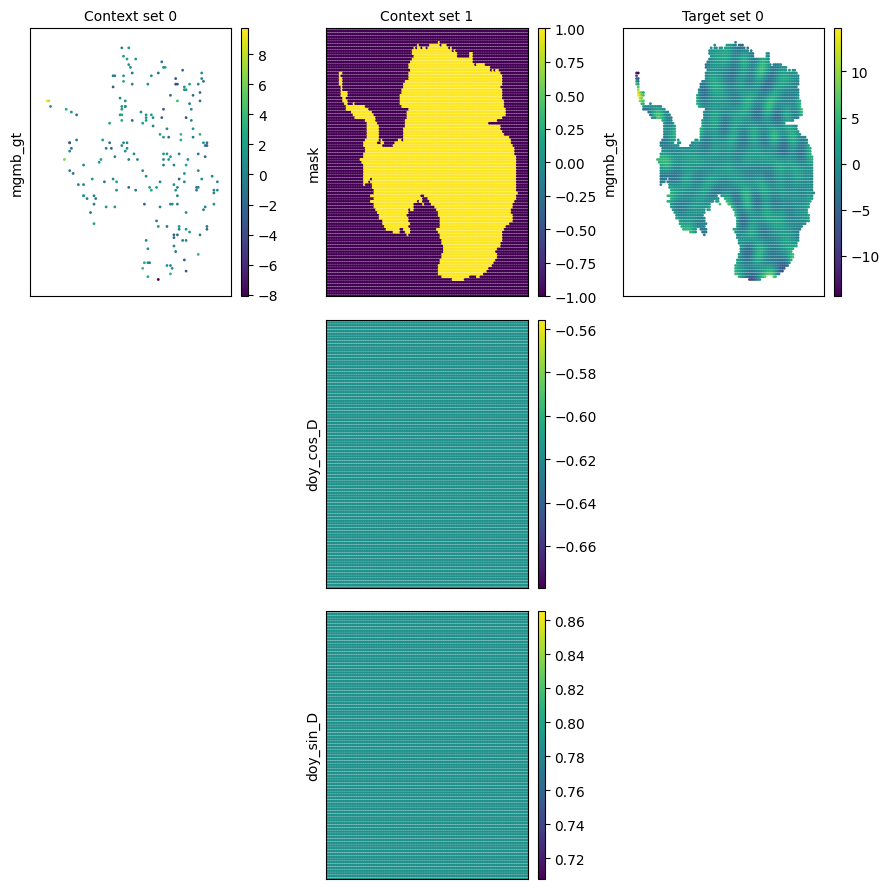

In [107]:
# draw an example task
example_task = task_loader(
    training_months[0],
    # context_sampling = [0.02, "all"], # 0.02: 100 points
    context_sampling = [200, "all"], # fix to 200 points
    target_sampling = "all")

example_task_small_context = task_loader(
    training_months[60], # switch month
    context_sampling = [10, "all"], # fix to 10 points
    target_sampling = "all")

# empty context task
empty_context_task = task_loader(
    training_months[70],
    context_sampling = [0, "all"], # no observations
    target_sampling = "all")

# dictionary of lists
print(example_task)

deepsensor.plot.task(example_task, task_loader)
# vmin and max are not set for vis
plt.show()

# Initialise model

Likelihood must me "gnp". This step might take 3 minutes even on GPU. 

In [15]:
# Overwriting the number of unet channels makes it smaller (less params)
model = deepsensor.model.ConvNP(
    data_processor, 
    task_loader, 
    likelihood = "gnp", # default is a cnp, GNP same as lowrank
    # num layers should be uneven (symmetry), e.g. 5?
    unet_channels = (32, 32, 32, 32, 32))

# Internal density is 102 by default: grid defines our resolution
print(f"Model has {deepsensor.backend.nps.num_params(model.model):,} parameters")
# Decoder scale is 1/internal density
# encoder scale is independent of internal density

print(model)

dim_yc inferred from TaskLoader: (1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 102
encoder_scales inferred from TaskLoader: [0.004901960784313725, 0.004901960492134094]
decoder_scale inferred from TaskLoader: 0.00980392156862745
Model has 341,157 parameters
ConvNP with config:
{
    "dim_x": 2,
    "dim_yc": [
        1,
        3
    ],
    "dim_yt": 1,
    "dim_aux_t": 0,
    "dim_lv": 0,
    "conv_arch": "unet",
    "unet_channels": [
        32,
        32,
        32,
        32,
        32
    ],
    "unet_resize_convs": true,
    "unet_resize_conv_interp_method": "bilinear",
    "aux_t_mlp_layers": null,
    "likelihood": "lowrank",
    "unet_kernels": 5,
    "internal_density": 102,
    "encoder_scales": [
        0.004901960784313725,
        0.004901960492134094
    ],
    "encoder_scales_learnable": false,
    "decoder_scale": 0.00980392156862745,
    "decoder_scale_learnable": false,
    "num_basis

"internal_density": 102 = ceil(sqrt(10379)) (97*102)

# Check prediction of untrained model

In [21]:
# single time slice (choose any), extract y and x and result the multi-level index
coordinates_df = mgmb_df.xs("2002-05-10", level = "time").reset_index()[["y", "x"]]
predictions_df = coordinates_df.copy()

# Extract
predictions_df["mean_val"] = model.mean(empty_context_task)[0]
predictions_df["var_val"] = model.variance(empty_context_task)[0]

# With the correct likelihood model we have small but non-zero covariances to start with
# model.covariance(empty_context_task)

In [22]:
fig = make_subplots(rows = 1, cols = 2)

fig.add_trace(go.Heatmap(
    z = predictions_df.mean_val,
                   x = predictions_df.x,
                   y = predictions_df.y,
                   colorscale = 'RdBu',
                   zmid = 0,
                   name = "mean"),
                   row = 1, col = 1,
)

fig.add_trace(go.Heatmap(
    z = predictions_df.var_val,
                   x = predictions_df.x,
                   y = predictions_df.y,
                   colorscale = 'gray_R', # white is higher certainty, black is the unknown
                   showscale = False),
                   row = 1, col = 2,
)

fig.update_layout(
    autosize = False,
    width = 950,
    height = 450,
    title = "Predicted mean and variance of the untrained model (normalised scale)")

fig.update_layout(template = "simple_white")
fig.update_layout(font_family = "Lato")

fig.update_xaxes(visible = False)
fig.update_yaxes(visible = False)

fig.show()

- bias changes with model initalisation
- We have some spatial shading from the mask or similar

## Encoding

Look at density channels of each context set.

SetConv encoding tensor shape: (1, 6, 128, 160)


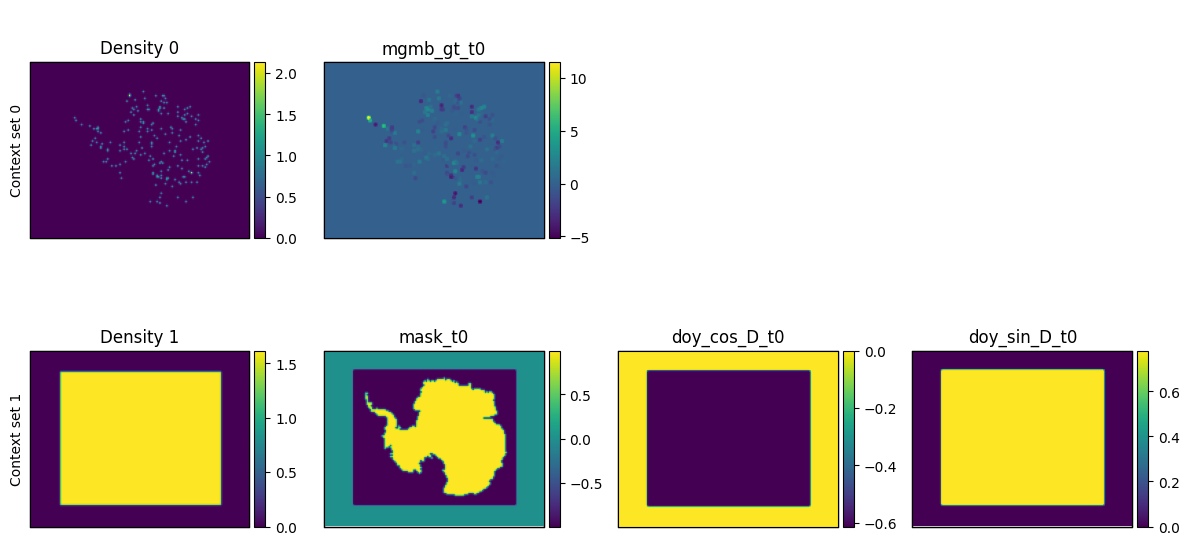

In [23]:
encoding = deepsensor.model.nps.compute_encoding_tensor(model, example_task)
print(f"SetConv encoding tensor shape: {encoding.shape}")

fig = deepsensor.plot.context_encoding(model, example_task, task_loader)
plt.show()

In [26]:
# helper function to generate tasks with varying number of context points
def gen_tasks(months, progress = False):
    # initalise empty list as conatiner for tasks
    tasks = []

    # Loop through all months
    # tqdm update
    for month in tqdm(months, disable = not progress):
        
        # Vary number of points in context between 20 and 200
        N_c = np.random.randint(20, 200)

        task = task_loader(month, 
                           context_sampling = [N_c, "all"], 
                           target_sampling = "all")
        
        # (not needed in off-grid setting) added "remove nans"
        # tasks.append(task.remove_target_nans())
        tasks.append(task)
    return tasks

# OPTIONAL: Interpolate or add some noise?

In [27]:
# call the function
# some issue with IProgress
validation_tasks = gen_tasks(validation_months, progress = False)
print(len(validation_tasks))

# print one of the tasks
validation_tasks[0]

63


time: Timestamp/2018-07-10 00:00:00
ops: []
X_c: ['ndarray/float32/(2, 74)', ('ndarray/float32/(1, 97)', 'ndarray/float32/(1, 117)')]
Y_c: ['ndarray/float32/(1, 74)', 'ndarray/float32/(3, 97, 117)']
X_t: ['ndarray/float32/(2, 4892)']
Y_t: ['ndarray/float32/(1, 4892)']

In [29]:
def compute_val_rmse(model, val_tasks):
    errors = []
    # extract name of target variable for reprojection
    target_var_ID = task_loader.target_var_IDs[0][0]  # assume 1st target set and 1D

    # loop over validation tasks
    for task in val_tasks:
        mean_pred = data_processor.map_array(model.mean(task), target_var_ID, unnorm = True)
        true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm = True)
        errors.extend(np.abs(mean_pred - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

In [ ]:
def compute_val_ll(model, val_tasks):
    errors = []
    # extract name of target variable for reprojection
    target_var_ID = task_loader.target_var_IDs[0][0]  # assume 1st target set and 1D

    # loop over validation tasks
    for task in val_tasks:
        mean_pred = data_processor.map_array(model.mean(task), target_var_ID, unnorm = True)
        true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm = True)
        errors.extend(np.abs(mean_pred - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

In [51]:
EPOCHS = 2

# deepsensor_folder = "models/deepsensor_config_offgrid/"
# deepsensor_folder = "models/deepsensor_config_offgrid_new/"
# deepsensor_folder = "models/deepsensor_monthly/"
deepsensor_folder = "models/deepsensor_experimental/"

# Likelihood
training_loss_per_epoch = []
val_loss_per_epoch = []
# RMSE
val_rmse_per_epoch = []

# initialise validation loss as inf
val_rmse_best = np.inf
# val_rmse_best = np.inf
trainer = Trainer(model, lr = 5e-5)

# selects only every xth item from a list through [::x]
date_subsample_factor = 1

for epoch in tqdm(range(EPOCHS), disable = True):

    # Generate training tasks
    # training_tasks = gen_tasks(training_months[::date_subsample_factor], progress = False)
    training_tasks = gen_tasks(training_months, progress = False)

    # TRAINING LOSS
    # list of training losses per task in epoch (or batch in epoch)
    training_losses = trainer(training_tasks)
    # append mean training loss of apoch
    training_loss_per_epoch.append(np.mean(training_losses))

    # VALIDATION LOSS
    val_rmse_per_epoch.append(compute_val_rmse(model, validation_tasks))

    # save model if training loss decreases
    # overfitting?
    if val_rmse_per_epoch[-1] < val_rmse_best:
        val_rmse_best = val_rmse_per_epoch[-1]
        # Save model
        model.save(deepsensor_folder)
    else:
        print("Epoch:", epoch, "The validation loss did not decrease. The model was not saved.")

    # SAVE 
    # Concat to generate two columns with training loss and validation loss
    training_folder = "training/"

    losses_array = np.concatenate((
        np.array(training_loss_per_epoch).reshape(-1, 1),
        np.array(val_rmse_per_epoch).reshape(-1, 1),), axis = 1)

    np.save(arr = losses_array, file = training_folder + "losses_array.npy")

    # PLOT
    # clear previous plot
    display.clear_output(wait = True)

    # new plot
    fig = make_subplots(rows = 1, cols = 2)

    fig.add_trace(
        go.Scatter(
            x = np.arange(0, EPOCHS), 
            y = training_loss_per_epoch,
            name = "Training loss (NLL)",
            line_color = "#636EFA"),
        row = 1, col = 1
    )

    fig.add_trace(
        go.Scatter(
            x = np.arange(0, EPOCHS), 
            y = val_rmse_per_epoch,
            name = "Validation loss (RMSE)",
            line_color = "navy",
            line_dash = "dash"),
        row = 1, col = 2
    )

    fig.update_layout(
        height = 400, width = 1100, title_text = "Training and Validation loss at epoch " + str(epoch),)

    fig.update_layout(template = "simple_white")
    fig.update_layout(font_family = "Lato")

    fig.show()
    # fig.close()

One epoch takes around 1:14 min

- We save the loss trajectories in "training/losses_array.npy"
    - There is both randomness in the training tasks and in the validation tasks.
    - Currently we don't resample the validation tasks though.

# Load trained model

In [96]:
trained_deepsensor_folder = "models/deepsensor_monthly/"
# trained_deepsensor_folder = "models/deepsensor_experimental/"
trained_model = deepsensor.model.ConvNP(data_processor, task_loader, trained_deepsensor_folder)

# Alternative
# create copy of model "shell"
# trained_model = model

# load trained params
# trained_model.load(model_ID = trained_deepsensor_folder)

# print(trained_model)

In [97]:
# single time slice
coordinates_df = mgmb_df.xs("2002-05-10", level = "time").reset_index()[["y", "x"]]
predictions_df = coordinates_df.copy()

# Extract
predictions_df["mean_val"] = trained_model.mean(empty_context_task)[0]
predictions_df["var_val"] = trained_model.variance(empty_context_task)[0]

fig = make_subplots(rows = 1, cols = 2)

fig.add_trace(go.Heatmap(
    z = predictions_df.mean_val,
                   x = predictions_df.x,
                   y = predictions_df.y,
                   colorscale = 'RdBu',
                   zmid = 0,
                   name = "mean"),
                   row = 1, col = 1,
)

fig.add_trace(go.Heatmap(
    z = predictions_df.var_val,
                   x = predictions_df.x,
                   y = predictions_df.y,
                   colorscale = 'gray_R',
                   showscale = False),
                   row = 1, col = 2,
)

fig.update_layout(
    autosize = False,
    width = 950,
    height = 450,
    title = "Unconditioned (learned) prior: Predicted mean and variance of the trained model (normalised scale)")

fig.update_layout(template = "simple_white")
fig.update_layout(font_family = "Lato")

fig.update_xaxes(visible = False)
fig.update_yaxes(visible = False)

fig.show()

In [101]:
task = example_task

# single time slice
coordinates_df = mgmb_df.xs("2002-05-10", level = "time").reset_index()[["y", "x"]]
predictions_df = coordinates_df.copy()

# Extract
predictions_df["mean_val"] = trained_model.mean(task)[0]
predictions_df["var_val"] = trained_model.variance(task)[0]

fig = make_subplots(rows = 1, cols = 2)

fig.add_trace(go.Heatmap(
    z = predictions_df.mean_val,
                   x = predictions_df.x,
                   y = predictions_df.y,
                   colorscale = 'RdBu',
                   zmid = 0,
                   name = "mean"),
                   row = 1, col = 1,
)

# Unnormalise function for tasks?! data_processor.unnormalise(task)
fig.add_trace(go.Scatter(
                   x = task["X_c"][0][1] * (data_processor.x2_map[1] - data_processor.x2_map[0]) + data_processor.x2_map[0],
                   y = task["X_c"][0][0] * (data_processor.x1_map[1] - data_processor.x1_map[0]) + data_processor.x1_map[0],
                   mode = 'markers',
                   marker = dict(size = 4, color = 'black', symbol = "x"),
                   showlegend = False),
                   row = 1, col = 1,
)

fig.add_trace(go.Heatmap(
    z = predictions_df.var_val,
                   x = predictions_df.x,
                   y = predictions_df.y,
                   colorscale = 'gray_R',
                   showscale = False),
                   row = 1, col = 2,
)

# Unnormalise function for tasks?! data_processor.unnormalise(task)
fig.add_trace(go.Scatter(
                   x = task["X_c"][0][1] * (data_processor.x2_map[1] - data_processor.x2_map[0]) + data_processor.x2_map[0],
                   y = task["X_c"][0][0] * (data_processor.x1_map[1] - data_processor.x1_map[0]) + data_processor.x1_map[0],
                   mode = 'markers',
                   marker = dict(size = 4, color = 'black', symbol = "x"),
                   showlegend = False),
                   row = 1, col = 2,
)

fig.update_layout(
    autosize = False,
    width = 950,
    height = 450, title = "Conditioned posterior: Predicted mean and variance of the trained model (normalised scale)")

fig.update_layout(template = "simple_white")
fig.update_layout(font_family = "Lato")

fig.update_xaxes(visible = False)
fig.update_yaxes(visible = False)

fig.show()

In [108]:
task = example_task_small_context

# single time slice
coordinates_df = mgmb_df.xs("2002-05-10", level = "time").reset_index()[["y", "x"]]
predictions_df = coordinates_df.copy()

# Extract
predictions_df["mean_val"] = trained_model.mean(task)[0]
predictions_df["var_val"] = trained_model.variance(task)[0]

fig = make_subplots(rows = 1, cols = 2)

fig.add_trace(go.Heatmap(
    z = predictions_df.mean_val,
                   x = predictions_df.x,
                   y = predictions_df.y,
                   colorscale = 'RdBu',
                   zmid = 0,
                   name = "mean"),
                   row = 1, col = 1,
)

# Unnormalise function for tasks?! data_processor.unnormalise(task)
fig.add_trace(go.Scatter(
                   x = task["X_c"][0][1] * (data_processor.x2_map[1] - data_processor.x2_map[0]) + data_processor.x2_map[0],
                   y = task["X_c"][0][0] * (data_processor.x1_map[1] - data_processor.x1_map[0]) + data_processor.x1_map[0],
                   mode = 'markers',
                   marker = dict(size = 4, color = 'black', symbol = "x"),
                   showlegend = False),
                   row = 1, col = 1,
)

fig.add_trace(go.Heatmap(
    z = predictions_df.var_val,
                   x = predictions_df.x,
                   y = predictions_df.y,
                   colorscale = 'gray_R',
                   showscale = False),
                   row = 1, col = 2,
)

# Unnormalise function for tasks?! data_processor.unnormalise(task)
fig.add_trace(go.Scatter(
                   x = task["X_c"][0][1] * (data_processor.x2_map[1] - data_processor.x2_map[0]) + data_processor.x2_map[0],
                   y = task["X_c"][0][0] * (data_processor.x1_map[1] - data_processor.x1_map[0]) + data_processor.x1_map[0],
                   mode = 'markers',
                   marker = dict(size = 4, color = 'black', symbol = "x"),
                   showlegend = False),
                   row = 1, col = 2,
)

fig.update_layout(
    autosize = False,
    width = 950,
    height = 450, title = "Conditioned posterior: Predicted mean and variance of the trained model (normalised scale)")

fig.update_layout(template = "simple_white")
fig.update_layout(font_family = "Lato")

fig.update_xaxes(visible = False)
fig.update_yaxes(visible = False)

fig.show()

# Sample

In [133]:
task = example_task_small_context

# This is wrong
# Drawing a sample takes time (1 min)
# sample = np.random.multivariate_normal(trained_model.mean(task).squeeze(), trained_model.covariance(task))

In [152]:
predictions_df = coordinates_df.copy()

# Extract
predictions_df["mean_val"] = sample

fig = make_subplots(rows = 1, cols = 2)

fig.add_trace(go.Heatmap(
    z = predictions_df.mean_val,
                   x = predictions_df.x,
                   y = predictions_df.y,
                   colorscale = 'RdBu',
                   zmid = 0,
                   name = "mean"),
                   row = 1, col = 1,
)

# Unnormalise function for tasks?! data_processor.unnormalise(task)
fig.add_trace(go.Scatter(
                   x = task["X_c"][0][1] * (data_processor.x2_map[1] - data_processor.x2_map[0]) + data_processor.x2_map[0],
                   y = task["X_c"][0][0] * (data_processor.x1_map[1] - data_processor.x1_map[0]) + data_processor.x1_map[0],
                   mode = 'markers',
                   marker = dict(size = 4, color = 'black', symbol = "x"),
                   showlegend = False),
                   row = 1, col = 1,
)

fig.update_layout(
    autosize = False,
    width = 950,
    height = 450, title = "Sample from posterior distribution")

fig.update_layout(template = "simple_white")
fig.update_layout(font_family = "Lato")

fig.update_xaxes(visible = False)
fig.update_yaxes(visible = False)

fig.show()

# Sample with integrated function

Documentation

https://alan-turing-institute.github.io/deepsensor/reference/model/model.html#deepsensor.model.model.ProbabilisticModel.sample 

In [167]:
N_samples = 3
auto_sample = trained_model.sample(task, n_samples = N_samples)
auto_sample.squeeze()[0]

array([-0.10139498, -0.05750647, -0.03515299, ...,  0.18668477,
        0.58092165, -0.3914112 ], dtype=float32)

In [173]:
N_samples = 3
auto_sample = trained_model.sample(task, n_samples = N_samples)

predictions_df = coordinates_df.copy()

fig = make_subplots(rows = 1, cols = N_samples)

for i in range(N_samples):
    # Add column to predictions_df
    predictions_df["mean_val_" + str(i)] = auto_sample.squeeze()[i]

    fig.add_trace(go.Heatmap(
                    z = predictions_df["mean_val_" + str(i)],
                    x = predictions_df.x,
                    y = predictions_df.y,
                    colorscale = 'RdBu',
                    zmid = 0,
                    name = "mean"),
                    row = 1, col = i + 1,
    )

    # Unnormalise function for tasks?! data_processor.unnormalise(task)
    fig.add_trace(go.Scatter(
                    x = task["X_c"][0][1] * (data_processor.x2_map[1] - data_processor.x2_map[0]) + data_processor.x2_map[0],
                    y = task["X_c"][0][0] * (data_processor.x1_map[1] - data_processor.x1_map[0]) + data_processor.x1_map[0],
                    mode = 'markers',
                    marker = dict(size = 4, color = 'black', symbol = "x"),
                    showlegend = False),
                    row = 1, col = i + 1,
    )

fig.update_layout(
    autosize = False,
    width = (450 * N_samples) + 50,
    height = 450, title = "Sample from posterior distribution")

fig.update_layout(template = "simple_white")
fig.update_layout(font_family = "Lato")

fig.update_xaxes(visible = False)
fig.update_yaxes(visible = False)

fig.show()

# Convert back into xarray dataset

In [102]:
# single time slice
prediction = mgmb_df.xs("2002-05-10", level = "time").reset_index()[["y", "x"]]
prediction["mean_preds"] = trained_model.mean(example_task)[0]
prediction["var_preds"] = trained_model.variance(example_task)[0]

prediction 

y         x  mean_preds  var_preds
0    -2100000.0  750000.0   -4.160933   7.067805
1    -2100000.0  800000.0   -5.425655   6.676723
2    -2100000.0  850000.0   -6.098516   5.650138
3    -2100000.0  900000.0   -5.840887   4.128674
4    -2100000.0  950000.0   -4.969928   3.576380
...         ...       ...         ...        ...
4887  2100000.0  350000.0   -0.254413   4.872725
4888  2100000.0  450000.0   -0.913450   5.167380
4889  2100000.0  500000.0   -1.293787   5.320187
4890  2100000.0  550000.0   -1.750023   5.750574
4891  2150000.0  350000.0    0.297064   7.443996

[4892 rows x 4 columns]

## Predict

- Why doesn#t this work with the task only?
- Need unnormalised (og) units

In [145]:
np.array(prediction[["x", "y"]]).T

array([[  750000.,   800000.,   850000., ...,   500000.,   550000.,
          350000.],
       [-2100000., -2100000., -2100000., ...,  2100000.,  2100000.,
         2150000.]])

In [146]:
# [0] to extract array
# preds = trained_model.predict(example_task, X_t = example_task["X_t"][0])
preds = trained_model.predict(example_task, X_t = np.array(prediction[["x", "y"]]).T)

preds

# Loss

In [174]:
# Score
model.logpdf(example_task)

-7774.9927

# Active learning

## Mean marginal entropy

In [175]:
# How is this calculated
model.mean_marginal_entropy(example_task)

# Extracts marginal (not joint) predictive distribution (mean and variance)
# model.mean(example_task)
# model.variance(example_task)

# same as (in-built entropy function)
model.slice_diag(example_task).entropy()
# same as (just a function of the predictive variance)
np.sum(0.5 * np.log(2 * np.pi * np.e * model.variance(example_task)))

7622.7676